In [1]:
# Copyright 2022, Donald Tillman.  All rights reserved.
# Plots for the distortion article.

from numpy import *
import matplotlib.pyplot as plt

# EIA color code
colors = ('black', 'brown', 'red', 'orange',  '#e0d030', 
          'green', 'blue', 'violet', 'gray', 'pink', 'black')

# x to dB
def db(x):
    return 20 * log10(maximum(abs(x), 1e-12))

# These next four functions build functions from functions.

# Given a nonlinear function, return a new function
# scaled and translated so the output goes from -1 to +1 
# as the input goes from -1 to +1.
def frame(fcn):
    scaled = 2 /(fcn(1) - fcn(-1))
    offset = -1 - scaled * fcn(-1)
    return lambda x: offset + scaled * fcn(x)

# Given a nonlinear function, return a new function
# of a push-pull pair.
def pushpull(fcn):
    return lambda x: fcn(x) - fcn(-x)

# Given a nonlinear function, return a new function 
# of two of these in series.
def series(fcn, inv=True):
    if inv:
        return lambda x: -1 * fcn(-1 * frame(fcn)(x))
    return lambda x: fcn(frame(fcn)(x))

# Given a nonlinear function, return a new function 
# with a negative feedback factor of b.
def feedback(b, fcn):
    ffcn = frame(fcn)
    def fb(x):
        y = x / (b + 1)
        for i in range(20):
            yn = ffcn(x - b * y)
            y = y + (yn - y) / (b + 1)
        return y
    return fb

# Given an array, perform an FFT and return
#   [[n, complexharmonic], ...]
# scaled to the fundamental,
# not including dc, fundamental, or harmonics below 80dB down.
def dist_spectrum(x):
    f = (fft.rfft(x)/len(x))[:11]
    return [(n, h)
            for n,h in enumerate(f/abs(f[1]))
            if 2 <= n and 1e-4 <= abs(h)]

# Given x and y arrays, add a point to the end ("Bakers Dozen")
# to make the drawings prettier.
def bakers(xs, ys):
    return append(xs, 2 * xs[-1] - xs[-2]), append(ys, ys[0])

# Pretty percent for the bar graph, taking up minimal space.
def percent(x):
    xp = 100 * abs(x)
    return f'{round(xp, 2 if xp < 1 else 1)}%'

# The inputs, used by the folks below.
xs = linspace(-1, 1, 256, endpoint=False)
vin = sin(xs * pi)

# Plot the transfer function curve on the axis.
# Include a sideways sine on the bottom.
def plot_tf(a, fcn, title):
    a.set_title(title)
    a.set_xlabel('Input Signal')
    a.set_ylabel('Output Signal')
    a.set_xticks(linspace(-1, 1, 5, endpoint=True))
    a.set_yticks(linspace(-1, 1, 5, endpoint=True))
    a.set_ylim((-1.35, 1.15))
    a.plot([-1, 1], [-1, 1], color='lightgray')
    a.plot([-1, 1], [0,  0], color='lightgreen')
    a.plot([-0, 0], [-1.15,  1], color='lightgreen')
    a.plot(xs, fcn(xs), color='#333333')
    a.plot(*(bakers(0.15 * xs - 1, vin)[-1::-1]), color='lightgray')

# Plot the distorted sine wave on the axis.
def plot_wave(a, fcn, title):
    a.set_title(title)
    a.set_xlabel('One cycle')
    a.set_ylabel('Output Signal')
    a.set_ylim((-1.35, 1.15))
    a.plot([-180, 180], [0,  0], color='lightgreen')
    a.plot([0, 0], [-1,  1], color='lightgreen')
    a.set_xticks(linspace(-180, 180, 9, endpoint=True))
    a.plot(*bakers(180 * xs, vin), color='lightgray')
    a.plot(*bakers(180 * xs, fcn(vin)), color='black')
        
# Draw a bar graph for the distortion spectrum on the axis.
def plot_dist_spectrum(a, fcn):
    a.set_axisbelow(True)
    a.set_title('Distortion spectrum')
    a.set_xlabel('Harmonic')
    a.set_ylabel('dB')
    sp = dist_spectrum(fcn(vin))
    ns, hs = tuple(zip(*sp)) or ((),())
    bar = a.bar(ns,
                80 + db(array(hs)),
                bottom=-80, 
                width=.5, 
                color=[colors[n] for n in ns])
    a.bar_label(bar, [percent(h) for h in hs])
    a.set_ylim((-80, 0))
    a.set_xlim((1, 8.3))
    a.set_xticks(arange(1, 9))
    thd = sum(abs(array(hs)))
    a.text(8, -10, f'{percent(thd)} total', horizontalalignment='right')
    
# Draw a pretty triptych of nonlinear curve, distorted sine,
# and distortion bar graph.
def triptych(fcn, title, filename=None):
    # this will have a side effect of undoing any inversion
    ffcn = frame(fcn)
    fig, axs = plt.subplots(1, 3, figsize=(10,3), 
                            gridspec_kw={'width_ratios': [.6, 1, .6]})
    plot_tf(axs[0], ffcn, title)
    plot_wave(axs[1], ffcn, 'Distorted sine wave')
    plot_dist_spectrum(axs[2], ffcn)
    plt.tight_layout()
    if filename:
        plt.savefig(filename)

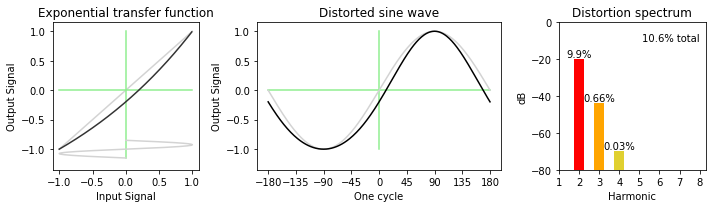

In [2]:
triptych(lambda x: exp(0.4 * x), 'Exponential transfer function', 'triptych-exp')

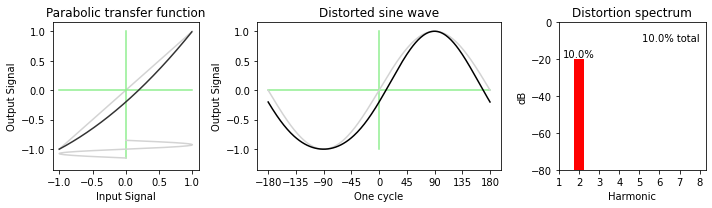

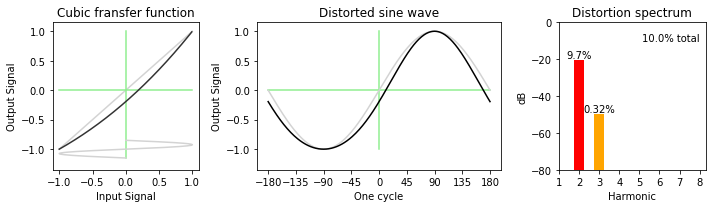

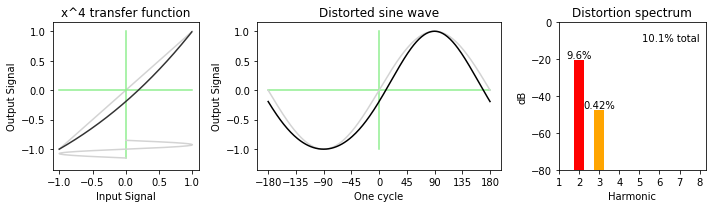

In [3]:
triptych(lambda x: (x + 2.5) ** 2, 'Parabolic transfer function', 'triptych-x2')
triptych(lambda x: (x + 5.1) ** 3, 'Cubic fransfer function', 'triptych-x3')
triptych(lambda x: (x + 7.7) ** 4, 'x^4 transfer function', 'triptych-x4')

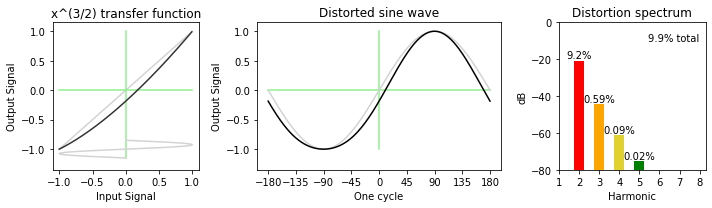

In [4]:
triptych(lambda x: (x + 1.43) ** 1.5, 'x^(3/2) transfer function', 'triptych-x32')

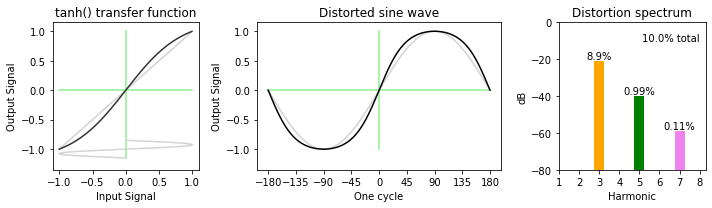

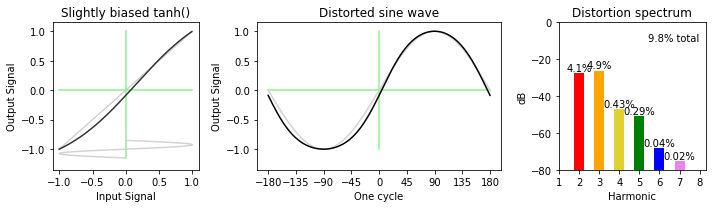

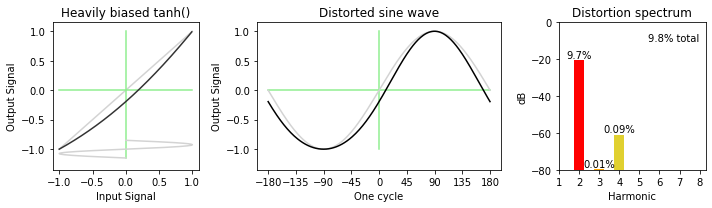

In [5]:
triptych(lambda x: tanh(1.2 * x), 'tanh() transfer function', 'triptych-tanh')
triptych(lambda x: tanh(.85 * (x - .15)), 'Slightly biased tanh()', 'triptych-tanh-b1')
triptych(lambda x: tanh(.34 * (x - 2)), 'Heavily biased tanh()', 'triptych-tanh-b2')

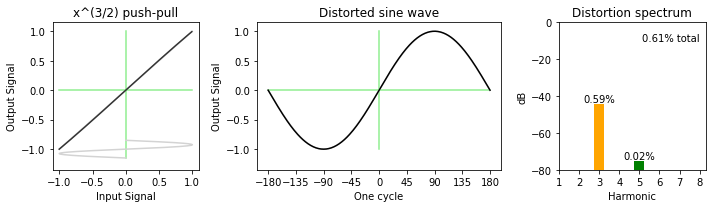

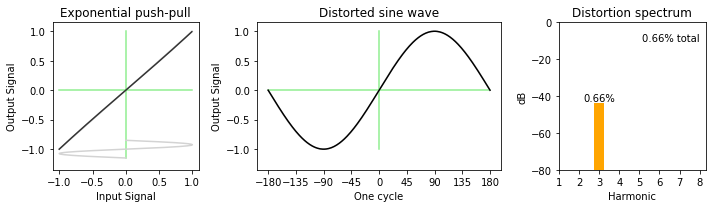

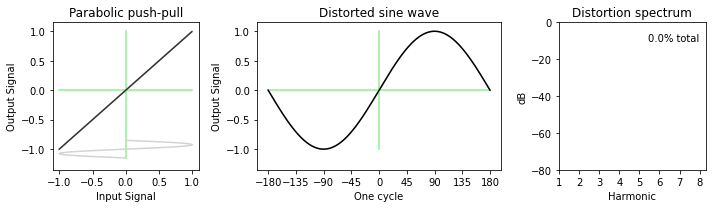

In [6]:
triptych(pushpull(lambda x: (x + 1.43) ** 1.5), 'x^(3/2) push-pull', 'triptych-32-pp')
triptych(pushpull(lambda x: exp(0.4 * x)), 'Exponential push-pull', 'triptych-exp-pp1')
triptych(pushpull(lambda x: (x + 2.5)), 'Parabolic push-pull', 'triptych-x2-pp')

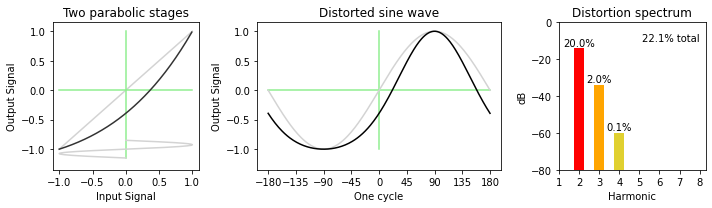

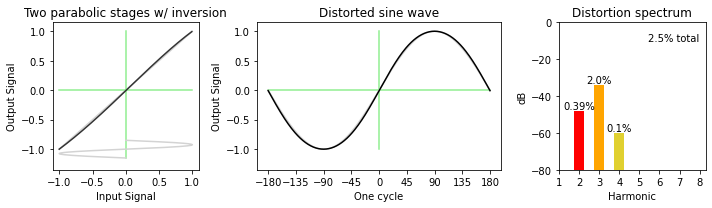

In [7]:
triptych(series(lambda x: (2.5 + x) ** 2, False), 'Two parabolic stages', 'triptych-x22')
triptych(series(lambda x: (2.5 + x) ** 2), 'Two parabolic stages w/ inversion', 'triptych-x2i2')

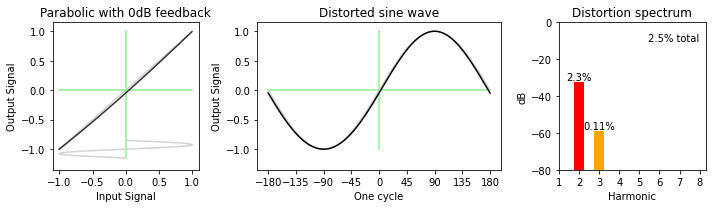

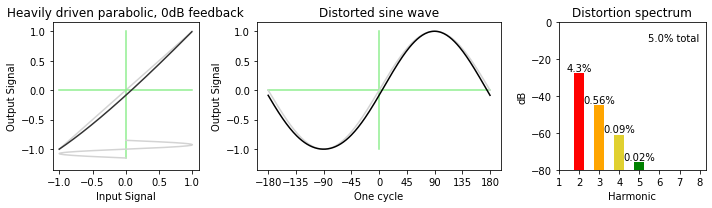

In [8]:
triptych(feedback(1, lambda x: (2.5 + x) ** 2), 'Parabolic with 0dB feedback', 'triptych-x2-fb')
triptych(feedback(1, lambda x: (2.5 + 4 * x) ** 2), 'Heavily driven parabolic, 0dB feedback', 'triptych-x2-fb-od')